In [1]:
import numpy as np 
import pandas as pd 
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd 
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from copy import deepcopy
from sklearn.feature_selection import f_classif
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.svm import LinearSVC
import pandas as pd
from scipy import stats
from statsmodels.stats import weightstats as stests

# Unpack Directory

In [2]:
paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))


train, test, gender = [pd.read_csv(path) for path in paths]

# Examining the dataset: 

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
print(f"The number of traning examples(data points) = {train.shape[0]}")
print(f"The number of features = {train.shape[1]}")

The number of traning examples(data points) = 891
The number of features = 12


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# **Checking for null values:**

In [7]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Theoretically, 25 to 30% is the maximum missing values are allowed, beyond which we might want to drop the variable from analysis. 

In [8]:
train.isnull().sum() / len(train)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

We can note that >25% of Cabin Data is null, hence it might be reasonable to just drop it completely. 

# Drop an Entire Column

In [9]:
train = train.drop(['Cabin'], axis=1)

In [10]:
train.drop('PassengerId', inplace=True, axis=1)

# Replace Null Values with Mean Values

In [11]:
train['Age'].fillna((train['Age'].mean()), inplace=True)

# Checking for duplicates

In [12]:
duplicate = train[train.duplicated()]
duplicate.size

0

# Binning

We can divide the age column into categories.
If we choose 6 classes, we would be going with intervals of 13. 

In [13]:
train['Age'].value_counts(bins=6, sort=False)

(0.339, 13.683]      71
(13.683, 26.947]    248
(26.947, 40.21]     422
(40.21, 53.473]     100
(53.473, 66.737]     43
(66.737, 80.0]        7
Name: Age, dtype: int64

# Binning Data

In [14]:
train['Age'].fillna((train['Age'].mean()), inplace=True)  # Fill nan values with mean age number 

bins = [0, 13, 26, 40, 53, 66, 80]
names = ['<13', '13-26', '26-40', '40-53', '53-66','66-80']

train['AgeCategory'] = pd.cut(train['Age'], bins, labels=names)

NumberedAgeCategories = {'<13': 0 , '13-26': 1, '26-40': 2, '40-53': 3, '53-66': 4,'66-80': 5}
train['AgeCategory'] = train['AgeCategory'].map(NumberedAgeCategories)  
train['AgeCategory'] = pd.to_numeric(train['AgeCategory'])
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeCategory
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,2
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,2
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,2


# Creating a New Column

Add the number of siblings/spouses to the parch (parch is also part of the family).

In [15]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1

# Outliers

# Boxplot

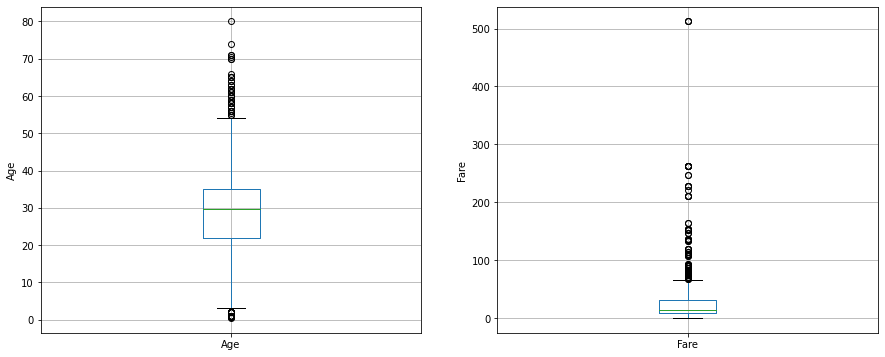

In [16]:
# Make boxplots to visualise outliers in the continuous variables-
# Age and Fare
 
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
fig = train.boxplot(column='Age')
fig.set_title('')
fig.set_ylabel('Age')
 
plt.subplot(1, 2, 2)
fig = train.boxplot(column='Fare')
fig.set_title('')
fig.set_ylabel('Fare');

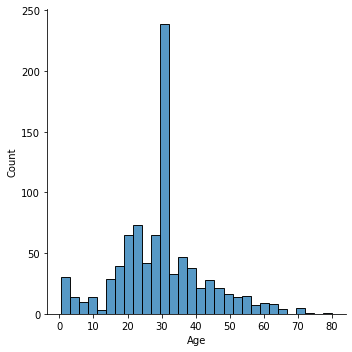

In [17]:
# Explore Age distribution 
sns.displot(train["Age"]);

# Detect outliers

In [18]:
upper, lower = [train.Age.mean() + sign * 3 * train.Age.std() for sign in [1, -1]]
print(f'Age outliers are values < {lower} or > {upper}')

Age outliers are values < -9.306928030949827 or > 68.70516332506747


In [19]:
outliers = train[train['Age']>upper]['Age']
outliers

96     71.0
116    70.5
493    71.0
630    80.0
672    70.0
745    70.0
851    74.0
Name: Age, dtype: float64

these values seem reasonable for the 'Age' feature, so we will leave them as they are. 

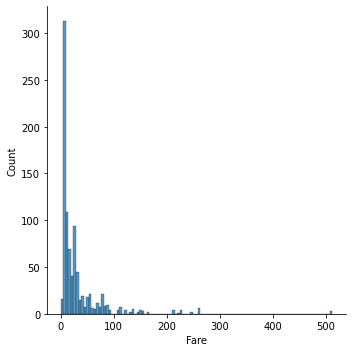

In [20]:
# Explore Fare distribution 
sns.displot(train["Fare"]);

Age has a normal distribution while the fare feature has skewed distribution.

As we can see, Fare distribution is very skewed. This can lead to overweighing very high values in the model, even if it is scaled.

In this case, it is better to transform it with the log function to reduce this skew.

# Map a Column to a Function

In [21]:
# Handle a right skewed distribution by taking the logarithm
train["Fare"] = train["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

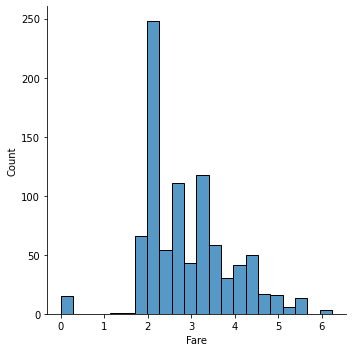

In [22]:
sns.displot(train["Fare"]);

# Preparing Data for the Model 

In [23]:
train.columns[train.dtypes==object]

Index(['Name', 'Sex', 'Ticket', 'Embarked'], dtype='object')

In [24]:
cleanup_nums = { "Embarked": 
                    {"S": 0, "C": 1, "Q": 2 },
                
                "Sex": 
                    {"male": 0, "female": 1}
               }

In [25]:
train.replace(cleanup_nums, inplace=True)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeCategory,FamilySize
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,0.0,1,2
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,1.0,2,2
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,0.0,1,1
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,0.0,2,2
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,0.0,2,1


In [26]:
train['Ticket'].unique().size

681

Extracting information from 'Name' column:

In [27]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [28]:
train['Family_name'] = train['Name'].str.split(', ').str[0]

train['Title'] = train['Name'].str.split(', ').str[1].str.split('.').str[0]

In [29]:
train['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [30]:
train['Title'] = train['Title'].replace(['Ms', 'Mlle'], 
                                            'Miss')
train['Title'] = train['Title'].replace(['Mme', 'Dona', 'the Countess', 'Lady'], 
                                            'Mrs')
train['Title'] = train['Title'].replace(['Rev', 'Mlle', 'Jonkheer', 'Dr', 'Capt', 'Don', 'Col', 'Major', 'Sir'],
                                            'Mr')

In [31]:
cleanup_nums = { "Title": 
                    {"Mr": 0, "Mrs": 1, "Miss": 2, "Master": 3}
               }
train.replace(cleanup_nums, inplace=True)


# Feature Selection

# Pearson's correlation

In [32]:
train.corr()
# here is a table that shows the correlation between each feature with the rest of the features.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,AgeCategory,FamilySize,Title
Survived,1.000000,-0.338481,0.543351,-0.069809,-0.035322,0.081629,0.331805,0.108669,-0.071179,0.016639,0.472168
Pclass,-0.338481,1.000000,-0.131900,-0.331339,0.083081,0.018443,-0.670489,0.043835,-0.298635,0.065997,-0.015231
Sex,0.543351,-0.131900,1.000000,-0.084153,0.114631,0.245489,0.264751,0.118593,-0.086463,0.200988,0.695022
Age,-0.069809,-0.331339,-0.084153,1.000000,-0.232625,-0.179191,0.103721,0.009499,0.961697,-0.248512,-0.398337
SibSp,-0.035322,0.083081,0.114631,-0.232625,1.000000,0.414838,0.323214,-0.060606,-0.221954,0.890712,0.323379
Parch,0.081629,0.018443,0.245489,-0.179191,0.414838,1.000000,0.336857,-0.079320,-0.189401,0.783111,0.342967
Fare,0.331805,-0.670489,0.264751,0.103721,0.323214,0.336857,1.000000,0.017080,0.084824,0.389193,0.245450
Embarked,0.108669,0.043835,0.118593,0.009499,-0.060606,-0.079320,0.017080,1.000000,0.047779,-0.081057,0.125604
AgeCategory,-0.071179,-0.298635,-0.086463,0.961697,-0.221954,-0.189401,0.084824,0.047779,1.000000,-0.246319,-0.383264
FamilySize,0.016639,0.065997,0.200988,-0.248512,0.890712,0.783111,0.389193,-0.081057,-0.246319,1.000000,0.392359


<AxesSubplot:>

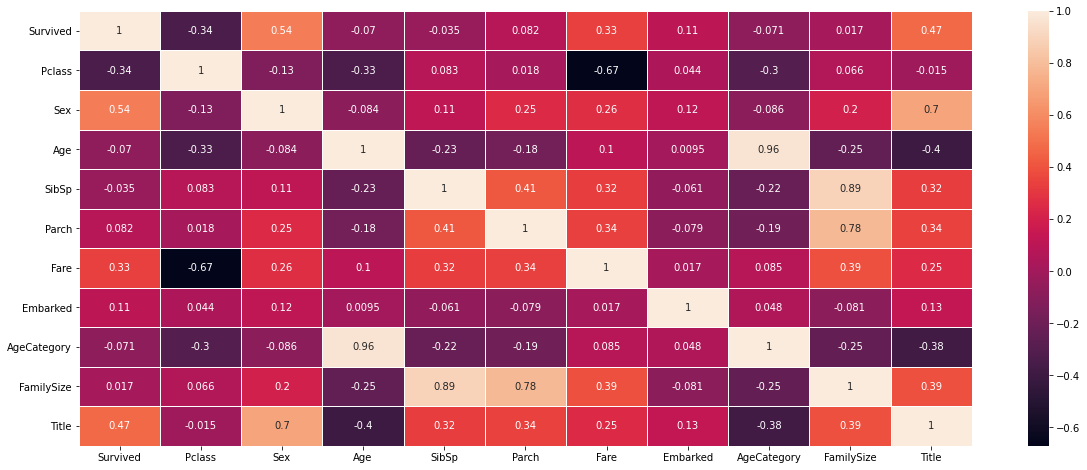

In [33]:
corr = train.corr()
f, ax = plt.subplots(figsize=(20, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, linewidths=.5, annot= True)

In [34]:
train.corr()['Survived'] 
# we will hone on the correlation values between the target feature since that's what we are investigating. 

Survived       1.000000
Pclass        -0.338481
Sex            0.543351
Age           -0.069809
SibSp         -0.035322
Parch          0.081629
Fare           0.331805
Embarked       0.108669
AgeCategory   -0.071179
FamilySize     0.016639
Title          0.472168
Name: Survived, dtype: float64

In [35]:
all_corr = train.corr()['Survived'].abs() >= .2
highly_correlated = all_corr[all_corr==True].index
# Only the features that have a correlation value of 0.2 or above with the target will be selected. 
highly_correlated = highly_correlated.tolist() 
highly_correlated.remove('Survived')
print('The number of features removed out of', all_corr.size, 'is', all_corr.size- len(highly_correlated),', leaving',len(highly_correlated),'selected features.')
highly_correlated

The number of features removed out of 11 is 7 , leaving 4 selected features.


['Pclass', 'Sex', 'Fare', 'Title']

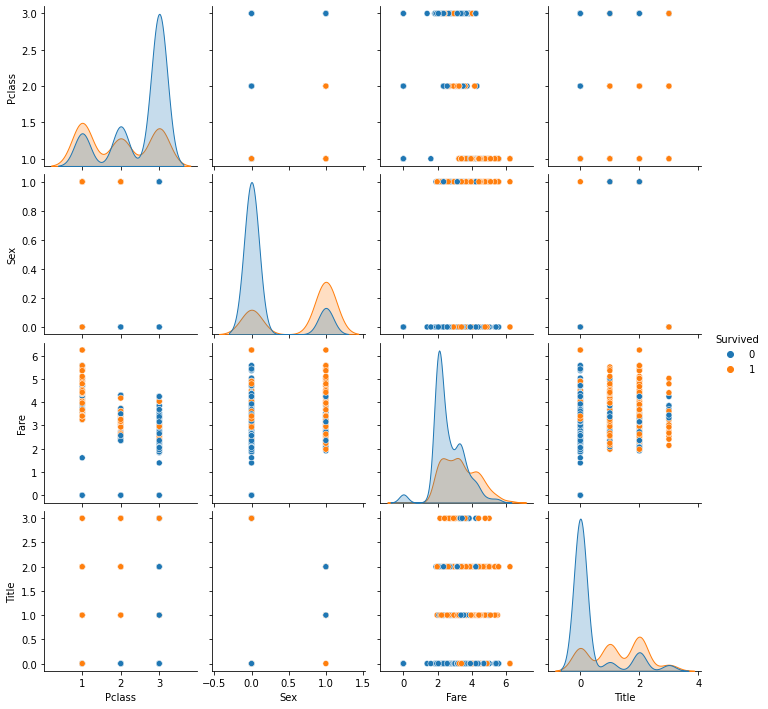

In [36]:
sns.pairplot(data=train[['Pclass', 'Sex', 'Fare', 'Title', 'Survived']],
             hue="Survived", dropna=True);

# Hypothesis testing

We still have columns that are not of numerical type so we need to change them before scaling/ running it on a model.

In [37]:
print(train.columns[train.dtypes == "object"])
train.head()

Index(['Name', 'Ticket', 'Family_name'], dtype='object')


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeCategory,FamilySize,Family_name,Title
0,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,0.0,1,2,Braund,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,1.0,2,2,Cumings,1
2,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,0.0,1,1,Heikkinen,2
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,0.0,2,2,Futrelle,1
4,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,0.0,2,1,Allen,0


In [38]:
#label encoder can also be used to transform non-numerical labels (as long as they are hashable and comparable) to numerical labels.
label_encoder = LabelEncoder()
for col in train.columns[train.dtypes == "object"]:
    train[col] = label_encoder.fit_transform(train[col].astype('str'))

for col in test.columns[test.dtypes == "object"]:
    test[col] = label_encoder.fit_transform(test[col].astype('str'))

# drop rows with null values    
train.dropna(inplace=True)

In [39]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeCategory,FamilySize,Family_name,Title
0,0,3,108,0,22.0,1,0,523,1.981001,0.0,1,2,73,0
1,1,1,190,1,38.0,1,0,596,4.266662,1.0,2,2,136,1
2,1,3,353,1,26.0,0,0,669,2.070022,0.0,1,1,251,2
3,1,1,272,1,35.0,1,0,49,3.972177,0.0,2,2,198,1
4,0,3,15,0,35.0,0,0,472,2.085672,0.0,2,1,11,0


In [40]:
# keep only the best 4 features according to p-values of ANOVA test
k_best = SelectKBest(f_classif, k=4)

In [41]:
X = train.drop('Survived', axis='columns')
y = train['Survived']
# fit the data and then tranform it.
k_best.fit_transform(X, y)

array([[3.        , 0.        , 1.98100147, 0.        ],
       [1.        , 1.        , 4.26666208, 1.        ],
       [3.        , 1.        , 2.07002232, 2.        ],
       ...,
       [3.        , 1.        , 3.15487049, 2.        ],
       [1.        , 0.        , 3.40119738, 0.        ],
       [3.        , 0.        , 2.04769284, 0.        ]])

In [42]:
# get the p values of columns
k_best.pvalues_
# make a dataframe of features and p-values
# sort that dataframe by p-value
p_values = pd.DataFrame({'column': X.columns, 'p_value': k_best.pvalues_}).sort_values('p_value')
# show the top 4 features
p_values.head(4)

,column,p_value
2,Sex,6.682012e-69
12,Title,2.587975e-50
0,Pclass,7.776916e-25
7,Fare,6.981649e-24


# Possible questions: 
- Is there a significant difference in the survival rate among people of different Pclasses? 
- Is there a significant difference in the survival rate between males and females? 

**Null Hypothesis( H0 ):** There is no difference in the survival rate between passengers females and males. <br>
**Alternative Hypothesis( HA )**: There is a difference in the survival rate between passengers females and males.

In [43]:
import random
male = train[train['Sex'] == 1]
female = train[train['Sex'] == 0]

## empty list for storing mean sample
m_mean_samples = []
f_mean_samples = []

for i in range(50):
    m_mean_samples.append(np.mean(random.sample(list(male['Survived']),50,)))
    f_mean_samples.append(np.mean(random.sample(list(female['Survived']),50,)))

We can use two-sampled ttests or two-sampled z-tests for this case, but since we chose our sample size to be greater than 30, z-tests would be preferrable.

We use repeated sampling from the same units. The test measures whether the average score differs significantly across samples. If we observe a large p-value, for example greater than 0.05 then we cannot reject the null hypothesis of identical survival rate. If the p-value is smaller than the threshold then we reject the null hypothesis of equal averages.

In [44]:
ttest, pval = stats.ttest_rel(m_mean_samples, f_mean_samples)
print(float(pval))
if pval < 0.05:
    print("Reject null hypothesis")
else:
    print("Accept null hypothesis")

8.413029775753978e-43
Reject null hypothesis


In [45]:
ztest ,pval1 = stests.ztest(m_mean_samples,f_mean_samples, value=0,alternative='two-sided')
if pval1 < 0.05:
    print("Reject null hypothesis")
else:
    print("Accept null hypothesis")

Reject null hypothesis


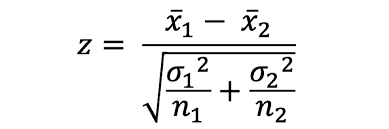

This graph illustrates the difference in survival rate among males and females:

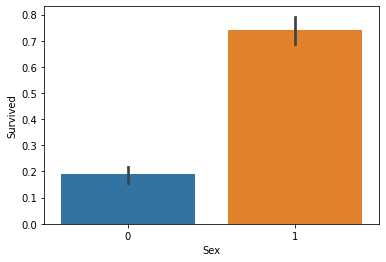

In [46]:
# Plot
sns.barplot(x=train['Sex'], y=train['Survived']);

**Null Hypothesis( H0 )**: There is no difference in the survival rate among passenger of different Pclasses. <br>
**Alternative Hypothesis( HA ):** There is a difference in the survival rate among passengers of different Pclasses.

We want to compare more than two groups at the same time, hence z-tests will not be suitable in this case. The analysis of variance or ANOVA is a statistical inference test that lets you compare multiple groups at the same time.
<br>
ANNOVA: Analysis of variance is a collection of statistical models and their associated estimation procedures used to analyze the differences among group means in a sample

In [47]:
grps = pd.unique(train.Pclass.values)
p1 = train[(train['Pclass']==1)]
p2 = train[(train['Pclass']==2)]
p3 = train[(train['Pclass']==3)]

p1_mean_samples=[]
p2_mean_samples=[]
p3_mean_samples=[]

for i in range(50):
    for j in range(1, 4):
        j = str(j)
        exec("p" + j + "_mean_samples.append(np.mean(random.sample(list(p" + j + "['Survived']),50,)))")
'''for i in range(50):
    p1_mean_samples.append(np.mean(random.sample(list(p1['Survived']),50,)))
    p2_mean_samples.append(np.mean(random.sample(list(p2['Survived']),50,)))
    p3_mean_samples.append(np.mean(random.sample(list(p3['Survived']),50,)))'''
                          
F, p = stats.f_oneway(p1_mean_samples, p2_mean_samples, p3_mean_samples)
print("p-value for significance is: ", p)
if p < 0.05:
    print("Reject null hypothesis")
else:
    print("Accept null hypothesis")

p-value for significance is:  7.622537651778441e-72
Reject null hypothesis


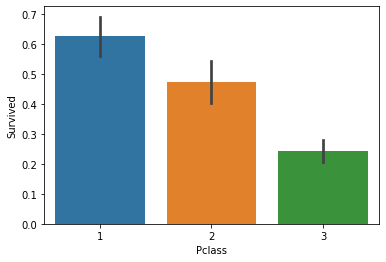

In [48]:
# Plot
sns.barplot(x=train['Pclass'],y=train['Survived']);

About 60% of the people travelling in the first class survived, while only around 25% of the people travelling in the third class survived. Accordingly, this plot suggests that the class in which people travel affects the chances of survival.

# Scaling

It is a step of data Pre-Processing which is applied to independent variables to normalize the data within a particular range. It also helps in speeding up the calculations in an algorithm. Scaling is important in the algorithms such as support vector machines (SVM) and k-nearest neighbors (KNN) where distance between the data points is important.


In [49]:
headers = train.columns
headers

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked', 'AgeCategory', 'FamilySize', 'Family_name',
       'Title'],
      dtype='object')

In [50]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeCategory,FamilySize,Family_name,Title
0,0,3,108,0,22.0,1,0,523,1.981001,0.0,1,2,73,0
1,1,1,190,1,38.0,1,0,596,4.266662,1.0,2,2,136,1
2,1,3,353,1,26.0,0,0,669,2.070022,0.0,1,1,251,2
3,1,1,272,1,35.0,1,0,49,3.972177,0.0,2,2,198,1
4,0,3,15,0,35.0,0,0,472,2.085672,0.0,2,1,11,0


# Standard Scaler

In [51]:
# Feature Scaling
## We will be using standardscaler to transform
from sklearn.preprocessing import StandardScaler
std_scale = StandardScaler()

## transforming "train_x"
train = std_scale.fit_transform(train)

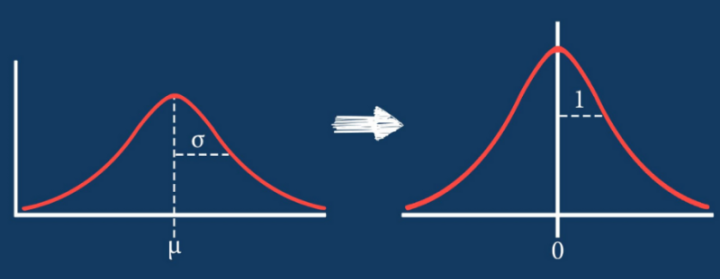

In [52]:
train = pd.DataFrame(train, columns=headers)
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeCategory,FamilySize,Family_name,Title
0,-0.786961,0.825209,-1.308847,-0.735342,-0.590495,0.431350,-0.474326,0.916911,-0.908614,-0.569684,-0.822292,0.057853,-1.306659,-0.730374
1,1.270711,-1.572211,-0.990076,1.359911,0.643971,0.431350,-0.474326,1.281117,1.374828,1.003139,0.216085,0.057853,-0.981016,0.325402
2,1.270711,0.825209,-0.356421,1.359911,-0.281878,-0.475199,-0.474326,1.645324,-0.819680,-0.569684,-0.822292,-0.561804,-0.386589,1.381179
3,1.270711,-1.572211,-0.671305,1.359911,0.412509,0.431350,-0.474326,-1.447936,1.080629,-0.569684,0.216085,0.057853,-0.660542,0.325402
4,-0.786961,0.825209,-1.670380,-0.735342,0.412509,-0.475199,-0.474326,0.662465,-0.804045,-0.569684,0.216085,-0.561804,-1.627133,-0.730374
